# データで見る ゲンロン 大森望 SF創作講座 2018

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set()

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%load_ext sql
%sql postgresql://fuji-nakahara@localhost/genron-school-sf-app_development

'Connected: fuji-nakahara@genron-school-sf-app_development'

In [4]:
term_id = 2018

In [5]:
from datetime import datetime
print(datetime.now())

2019-03-25 01:32:42.559945


## 作品提出数の推移

In [6]:
%%sql subjects <<

select
    s.number
    , s.title
    , l.name as proposer
    , s.synopses_count
    , count(sy.id) as selected_synopses_count
    , s.works_count
from
    subjects s
    left join lecturers l on (s.id = l.subject_id and ('課題提示' = any (l.roles)))
    left join synopses sy on (s.id = sy.subject_id and sy.selected = True)
where
    s.term_id = :term_id
    and s.number <= 10
group by
    1, 2, 3, 4, 6
order by
    1

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable subjects


In [7]:
subjects

,number,title,proposer,synopses_count,selected_synopses_count,works_count
0,1,AIあるいは仮想通貨を題材に短編を書け,東浩紀,43,4,9
1,2,スキットがなきゃ意味がない,藤井太洋,35,3,12
2,3,生き物を作ってみよう！,新井素子,31,3,16
3,4,拘束下で書きなさい,円城塔,31,4,9
4,5,来たるべき読者のための「初めてのSF」,法月綸太郎,27,4,12
5,6,キャラクターの関係性で物語を回しなさい,長谷敏司,25,4,11
6,7,経過時間を設定してください,飛浩隆,23,3,11
7,8,「天皇制」、または「元号」に関するSFを書きなさい。,小川哲,23,4,5
8,9,小さな世界を見せてください,森岡浩之,22,4,7
9,10,最終課題：ゲンロンSF新人賞【梗概】,None,22,0,0


In [8]:
subjects[['synopses_count', 'selected_synopses_count', 'works_count']].sum()

synopses_count             282
selected_synopses_count     33
works_count                 92
dtype: int64

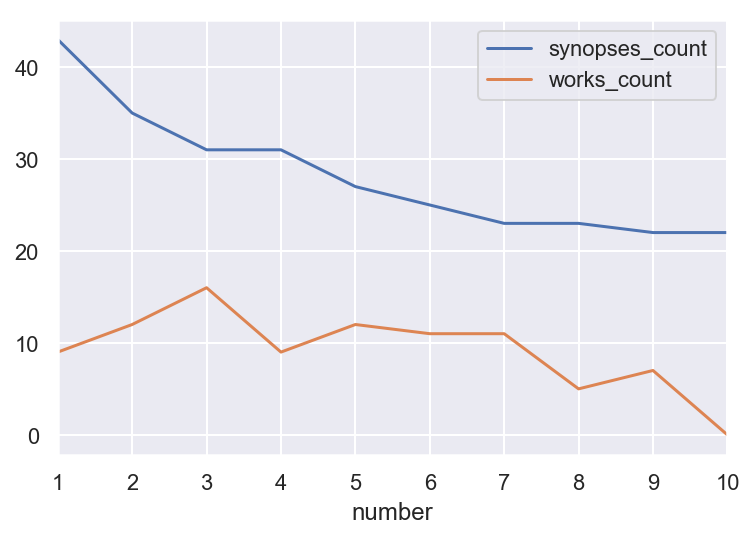

In [9]:
subjects.plot(x='number', y=['synopses_count', 'works_count'])

## 選出・得点機会

In [10]:
%%sql student_synopses <<

select
    name
    , submitted_count
    , selected_count
    , coalesce(characters_sum / submitted_count::real, 0) as characters_ave
    , coalesce(max_character_count, 0) as max_character_count
    , coalesce(appeal_characters_sum / submitted_count::real, 0) as appeal_characters_ave
    , coalesce(max_appeal_character_count, 0) as max_appeal_character_count
from
    (
        select
            s.original_id
            , s.name
            , count(sy.id) as submitted_count
            , sum(case when sy.selected then 1 else 0 end) as selected_count
            , sum(sy.character_count) as characters_sum
            , max(sy.character_count) as max_character_count
            , sum(sy.appeal_character_count) as appeal_characters_sum
            , max(sy.appeal_character_count) as max_appeal_character_count
        from
            students s
            join students_terms st on s.id = st.student_id
            left join (
                select
                    sy.*
                from
                    synopses sy
                    join subjects su on (
                        sy.subject_id = su.id
                        and su.term_id = :term_id
                    )
            ) sy on s.id = sy.student_id
        where
            st.term_id = :term_id
        group by
            1, 2
    ) student_synopses
order by
    original_id

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable student_synopses


In [11]:
%%sql student_works <<

select
    name
    , submitted_count
    , submitted_count - selected_count as optional_count
    , coalesce(score, 0) as score
    , optional_score
    , coalesce(characters_sum, 0) as characters_sum
from
    (
        select
            s.original_id
            , s.name
            , count(w.id) as submitted_count
            , sum(case when w.selected = True then 1 else 0 end) as selected_count
            , sum(w.score) as score
            , sum(case when w.selected != True then w.score else 0 end) as optional_score
            , sum(w.character_count) as characters_sum
        from
            students s
            join students_terms st on s.id = st.student_id
            left join (
                select
                    w.*
                    , sy.selected
                from
                    works w
                    join subjects su on (
                        w.subject_id = su.id
                        and su.term_id = :term_id
                    )
                    left join synopses sy using (original_id)
            ) w on s.id = w.student_id
        where
            st.term_id = :term_id
        group by
            1, 2
    ) student_synopses
order by
    original_id

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable student_works


### 受講生一人あたりの梗概提出数・選出数

In [12]:
student_synopses[['submitted_count', 'selected_count']].describe()

,submitted_count,selected_count
count,48.000000,48.000000
mean,5.875000,0.687500
std,3.600384,1.113863
min,0.000000,0.000000
25%,2.000000,0.000000
50%,6.000000,0.000000
75%,10.000000,1.000000
max,10.000000,4.000000


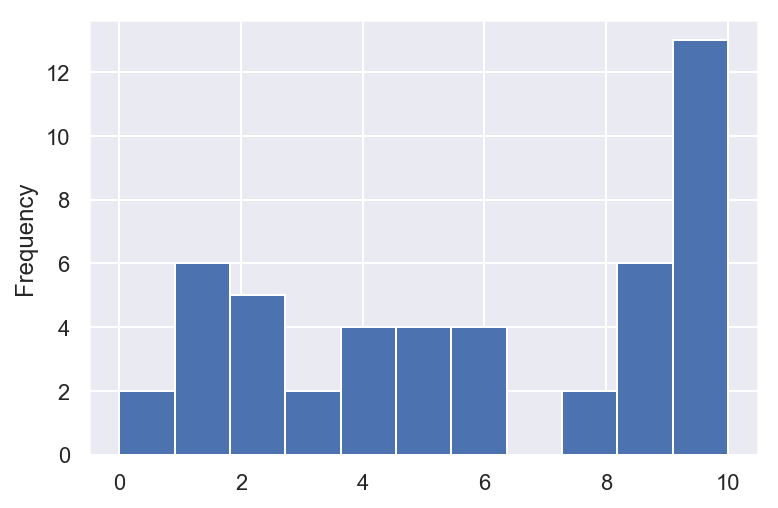

In [13]:
student_synopses.submitted_count.plot.hist(bins=11)

### 受講生一人あたりの実作提出数・選出数

In [14]:
student_works[['submitted_count', 'optional_count']].describe()

,submitted_count,optional_count
count,48.000000,48.000000
mean,1.916667,1.312500
std,2.656452,2.105275
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,3.250000,2.250000
max,9.000000,7.000000


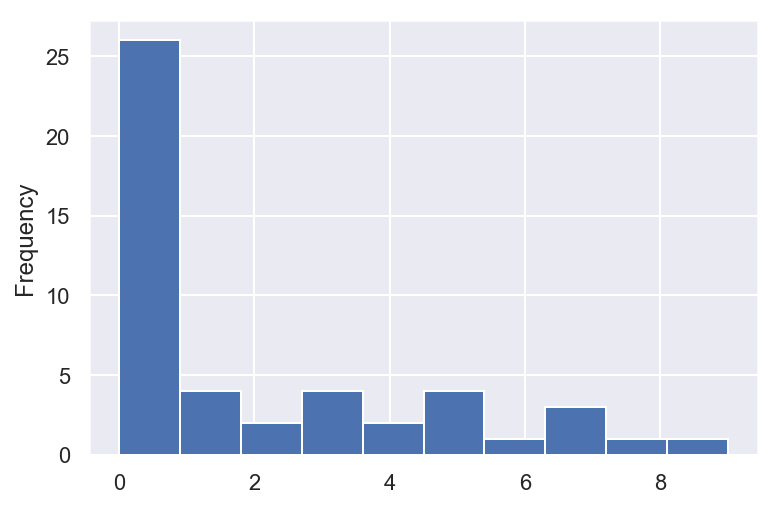

In [15]:
student_works.submitted_count.plot.hist(bins=10)

### 得点した自主提出作品

In [16]:
%%sql

select
    su.number
    , su.title as subject_title
    , w.title as work_title
    , s.name as author
    , w.score
from
    works w
    join students s on w.student_id = s.id
    join subjects su on (
        w.subject_id = su.id
        and su.term_id = :term_id
    )
    left join synopses sy on (w.original_id = sy.original_id)
where
    sy.selected != True
    and w.score > 0
order by
    1, s.original_id

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development


,number,subject_title,work_title,author,score
0,1,AIあるいは仮想通貨を題材に短編を書け,子どもだましの森,遠山軌道,1
1,2,スキットがなきゃ意味がない,揺りかごの外から,遠山軌道,2
2,2,スキットがなきゃ意味がない,飲鴆止活（いんちんしかつ）,斧田 小夜,1
3,3,生き物を作ってみよう！,「蝗の王」,伊藤 元晴,2
4,3,生き物を作ってみよう！,肉のシャイロック,国分寺崖線,1
5,3,生き物を作ってみよう！,イキワカレノイモウト,進藤尚典,2
6,5,来たるべき読者のための「初めてのSF」,ナンバー・オブ・マイ・ルート,伊藤 元晴,1
7,5,来たるべき読者のための「初めてのSF」,はじめましてSci-Fiさん、エイリアンより,黒田 渚,1
8,5,来たるべき読者のための「初めてのSF」,ギークに銃はいらない,斧田 小夜,5
9,7,経過時間を設定してください,スシュランの男,斧田 小夜,2


## 梗概の文字数

In [17]:
%%sql synopses_character_counts <<

select
    s.number as subject_number
    , sy.title
    , st.name as author
    , sy.character_count
    , sy.appeal_character_count
    , sy.selected
from
    subjects s
    join synopses sy on (
        s.id = sy.subject_id
        and sy.original_id != 2561 /* 茶里 裕治『オペレーション・パトリオット』非公開化のため */
    )
    join students st on sy.student_id = st.id
where
    s.term_id = :term_id
    and s.number <= 9
order by
    1

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable synopses_character_counts


### 全梗概の文字数に関する統計量

In [18]:
synopses_character_counts.fillna(0)[['character_count', 'appeal_character_count']].describe()

,character_count,appeal_character_count
count,259.000000,259.000000
mean,1424.957529,329.000000
std,383.521851,231.076383
min,310.000000,0.000000
25%,1196.500000,182.500000
50%,1262.000000,319.000000
75%,1597.500000,398.000000
max,3517.000000,1967.000000


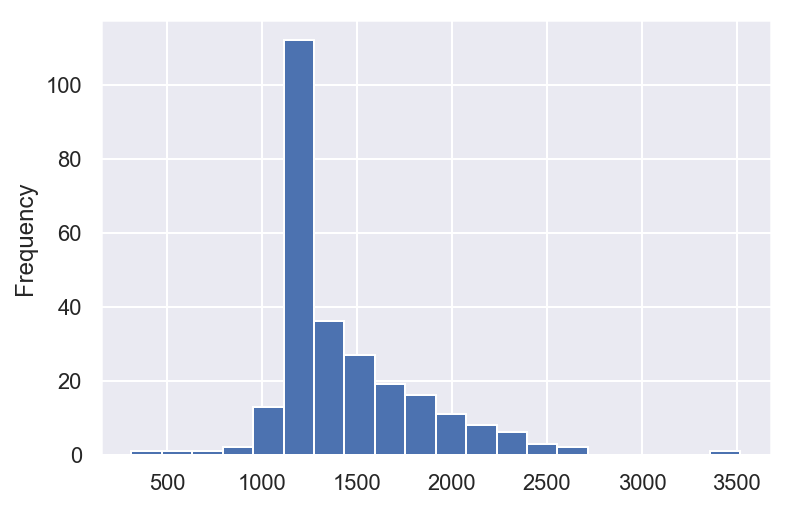

In [19]:
synopses_character_counts.character_count.plot.hist(bins=20)

### 選出梗概の文字数に関する統計量

In [20]:
synopses_character_counts.fillna(0)[synopses_character_counts.selected][['character_count', 'appeal_character_count']].describe()

,character_count,appeal_character_count
count,32.000000,32.00000
mean,1514.312500,341.12500
std,366.289189,176.18351
min,1087.000000,0.00000
25%,1198.000000,254.50000
50%,1409.500000,323.50000
75%,1759.000000,400.00000
max,2418.000000,1035.00000


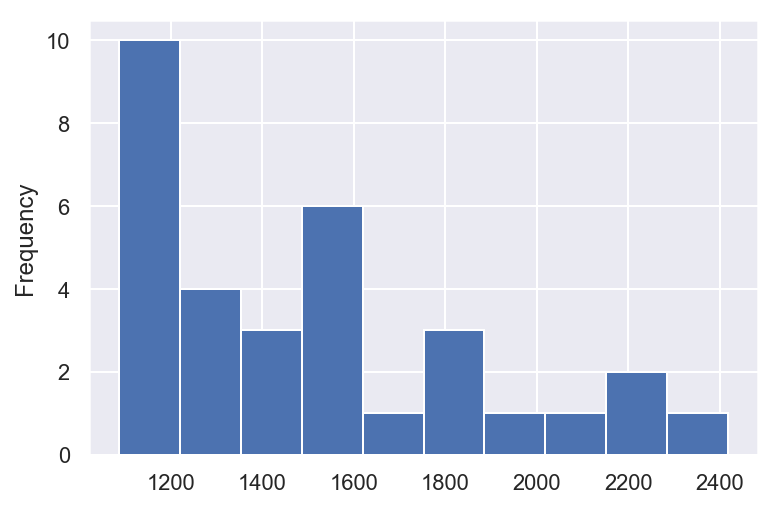

In [21]:
synopses_character_counts[synopses_character_counts.selected].character_count.plot.hist()

In [22]:
synopses_character_counts[synopses_character_counts.selected].sort_values(by='character_count')

,subject_number,title,author,character_count,appeal_character_count,selected
250,9,最古にして最新の弔い作法,小野 十郎,1087,224.0,True
233,8,酔来酔去,斧田 小夜,1126,255.0,True
180,6,フィオナの空、ロアの海,斧田 小夜,1148,340.0,True
83,3,死者の裔,武見 倉森,1154,248.0,True
10,1,これからの祈りについて,斧田 小夜,1168,327.0,True
7,1,AI、無人島を脱出できず,進藤尚典,1179,289.0,True
103,3,流星雨があがったら,揚羽はな,1196,296.0,True
155,5,暴走ロケットに乗れ！,揚羽はな,1198,276.0,True
9,1,涜神のスティグマ,維嶋津/いしましん,1198,393.0,True
41,1,暗点,国分寺崖線,1200,394.0,True


### 課題ごとの梗概文字数

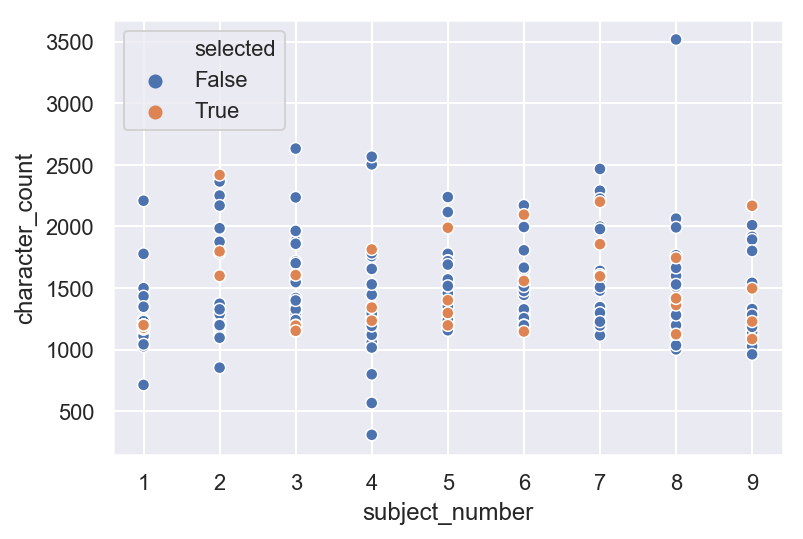

In [23]:
sns.scatterplot(x='subject_number', y='character_count', hue='selected', data=synopses_character_counts.sort_values(by='selected'))

## 受講生いろいろランキング

### 梗概

In [24]:
student_synopses

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count
0,伊藤 元晴,10,2,1431.000000,1746,194.500000,383
1,亜月,6,0,1161.333333,1716,241.833333,352
2,甘木 零,9,1,1490.333333,1860,582.333333,1035
3,茶里 裕治,10,1,1803.100000,3714,239.500000,375
4,遠山軌道,9,1,1502.888889,2168,241.222222,688
5,篠田 航平,8,0,1487.125000,1876,338.875000,544
6,夢想 真,10,0,1346.900000,1531,211.400000,507
7,フジ・ナカハラ,6,3,1472.333333,2239,410.666667,471
8,宿禰,6,1,1946.666667,3517,289.000000,371
9,灰田 頼人,5,0,1545.600000,2566,208.600000,382


#### 梗概提出皆勤賞

In [25]:
student_synopses[student_synopses.submitted_count == 10]

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count
0,伊藤 元晴,10,2,1431.0,1746,194.5,383
3,茶里 裕治,10,1,1803.1,3714,239.5,375
6,夢想 真,10,0,1346.9,1531,211.4,507
19,武見 倉森,10,2,1433.4,1840,340.6,660
21,国分寺崖線,10,2,1933.2,2504,527.3,1178
25,谷 美里,10,2,2002.8,2209,590.6,1359
27,諸根 いつみ,10,0,1210.7,1240,269.2,395
34,進藤尚典,10,2,1354.5,1666,186.5,379
39,野咲タラ,10,0,1139.5,1665,420.4,822
41,安藤 タカシ,10,0,1291.0,2011,276.0,424


#### 文字数遵守

In [26]:
student_synopses[(student_synopses.max_character_count <= 1200) & (student_synopses.submitted_count >= 5)].sort_values(by='max_character_count').head()

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count
44,揚羽はな,10,2,1197.6,1200,305.5,373


#### 5回以上の提出で平均文字数1200字以下

In [27]:
student_synopses[(student_synopses.characters_ave <= 1200) & (student_synopses.submitted_count >= 5)].sort_values(by='characters_ave')

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count
39,野咲タラ,10,0,1139.500000,1665,420.400000,822
37,げんなり,9,0,1140.555556,1328,154.666667,289
1,亜月,6,0,1161.333333,1716,241.833333,352
44,揚羽はな,10,2,1197.600000,1200,305.500000,373


#### 平均超過ワースト5

In [28]:
student_synopses[student_synopses.submitted_count >= 2].sort_values(by='characters_ave', ascending=False).head()

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count
25,谷 美里,10,2,2002.800000,2209,590.600000,1359
8,宿禰,6,1,1946.666667,3517,289.000000,371
21,国分寺崖線,10,2,1933.200000,2504,527.300000,1178
3,茶里 裕治,10,1,1803.100000,3714,239.500000,375
45,ヤナギサワ カズキ,9,0,1699.777778,2226,346.111111,449


#### 梗概選出回数

In [29]:
student_synopses[student_synopses.selected_count >= 3].sort_values(by='selected_count', ascending=False)

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count
43,斧田 小夜,10,4,1253.100000,1640,311.600000,520
7,フジ・ナカハラ,6,3,1472.333333,2239,410.666667,471
16,維嶋津/いしましん,9,3,1445.222222,2865,341.555556,774
29,小野 十郎,8,3,1679.000000,2467,466.625000,1428
47,琴柱遥,10,3,1518.900000,1857,407.000000,566


#### 梗概選出率

In [30]:
selected_rate = (student_synopses.selected_count / student_synopses.submitted_count).fillna(0)
selected_rate.name = 'selected_rate'
pd.concat([student_synopses, selected_rate], axis=1).sort_values(by='selected_rate', ascending=False).head()

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count,selected_rate
7,フジ・ナカハラ,6,3,1472.333333,2239,410.666667,471,0.500000
43,斧田 小夜,10,4,1253.100000,1640,311.600000,520,0.400000
29,小野 十郎,8,3,1679.000000,2467,466.625000,1428,0.375000
16,維嶋津/いしましん,9,3,1445.222222,2865,341.555556,774,0.333333
47,琴柱遥,10,3,1518.900000,1857,407.000000,566,0.300000


### 実作

In [31]:
student_works

,name,submitted_count,optional_count,score,optional_score,characters_sum
0,伊藤 元晴,7,5,22,3,119855
1,亜月,0,0,0,0,0
2,甘木 零,7,6,8,3,101547
3,茶里 裕治,1,0,7,0,54
4,遠山軌道,4,4,3,3,83332
5,篠田 航平,0,0,0,0,0
6,夢想 真,0,0,0,0,0
7,フジ・ナカハラ,2,0,2,0,33434
8,宿禰,3,2,11,0,43795
9,灰田 頼人,0,0,0,0,0


#### 実作提出回数

In [32]:
student_works[student_works.submitted_count >= 7].sort_values(by='submitted_count', ascending=False)

,name,submitted_count,optional_count,score,optional_score,characters_sum
43,斧田 小夜,9,5,41,11,194215
34,進藤尚典,8,6,12,2,103795
0,伊藤 元晴,7,5,22,3,119855
2,甘木 零,7,6,8,3,101547
39,野咲タラ,7,7,2,2,91901


#### 自主提出得点

In [33]:
student_works[student_works.optional_score >= 3].sort_values(by='optional_score', ascending=False)

,name,submitted_count,optional_count,score,optional_score,characters_sum
43,斧田 小夜,9,5,41,11,194215
27,諸根 いつみ,5,5,4,4,91385
0,伊藤 元晴,7,5,22,3,119855
2,甘木 零,7,6,8,3,101547
4,遠山軌道,4,4,3,3,83332


#### 実作総文字数

In [34]:
student_works.sort_values(by='characters_sum', ascending=False).head()

,name,submitted_count,optional_count,score,optional_score,characters_sum
43,斧田 小夜,9,5,41,11,194215
0,伊藤 元晴,7,5,22,3,119855
34,進藤尚典,8,6,12,2,103795
2,甘木 零,7,6,8,3,101547
47,琴柱遥,4,1,46,0,100798
